In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/airplane-accidents-severity-dataset/train.csv
/kaggle/input/airplane-accidents-severity-dataset/test.csv
/kaggle/input/airplane-accidents-severity-dataset/sample_submission.csv


### Import Libraries

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from warnings import filterwarnings
filterwarnings('ignore')
%matplotlib inline

### Read CSV Files

In [15]:
import pandas as pd
sample_submission = pd.read_csv("../input/airplane-accidents-severity-dataset/sample_submission.csv")
test = pd.read_csv("../input/airplane-accidents-severity-dataset/test.csv")
data = pd.read_csv("../input/airplane-accidents-severity-dataset/train.csv")

### Taking dependent Variables on X and target variable on Y

In [16]:
X = data.iloc[:,1:]
y = data['Severity']

In [17]:
data.head()

,Severity,Safety_Score,Days_Since_Inspection,Total_Safety_Complaints,Control_Metric,Turbulence_In_gforces,Cabin_Temperature,Accident_Type_Code,Max_Elevation,Violations,Adverse_Weather_Metric,Accident_ID
0,Minor_Damage_And_Injuries,49.223744,14,22,71.285324,0.272118,78.04,2,31335.476824,3,0.424352,7570
1,Minor_Damage_And_Injuries,62.465753,10,27,72.288058,0.423939,84.54,2,26024.711057,2,0.352350,12128
2,Significant_Damage_And_Fatalities,63.059361,13,16,66.362808,0.322604,78.86,7,39269.053927,3,0.003364,2181
3,Significant_Damage_And_Serious_Injuries,48.082192,11,9,74.703737,0.337029,81.79,3,42771.499200,1,0.211728,5946
4,Significant_Damage_And_Fatalities,26.484018,13,25,47.948952,0.541140,77.16,3,35509.228515,2,0.176883,9054


### Converting target variable categories to numbers

In [18]:
severity_map = {'Minor_Damage_And_Injuries':0,'Significant_Damage_And_Fatalities':1,
                'Highly_Fatal_And_Damaging':2,'Significant_Damage_And_Serious_Injuries':3}
y = y.map(severity_map)
severity_inv_map = {0:'Minor_Damage_And_Injuries',1:'Significant_Damage_And_Fatalities',
                2:'Highly_Fatal_And_Damaging',3:'Significant_Damage_And_Serious_Injuries'}

In [19]:
X.columns

Index(['Safety_Score', 'Days_Since_Inspection', 'Total_Safety_Complaints',
       'Control_Metric', 'Turbulence_In_gforces', 'Cabin_Temperature',
       'Accident_Type_Code', 'Max_Elevation', 'Violations',
       'Adverse_Weather_Metric', 'Accident_ID'],
      dtype='object')

### Feature Selection

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
model= RandomForestClassifier()
selector=RFE(model,5)
selector.fit(X,y)
print(selector.ranking_)


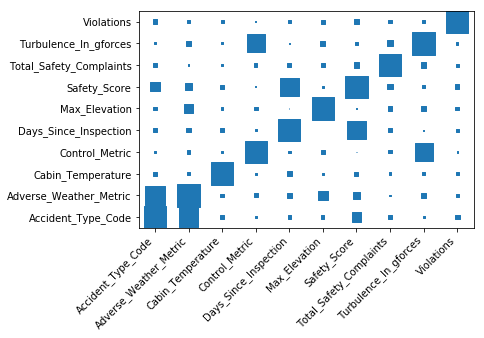

In [20]:
def heatmap(x, y, size):
    fig, ax = plt.subplots()
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 500
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        marker='s' # Use square as scatterplot marker
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    
data = pd.read_csv("../input/airplane-accidents-severity-dataset/train.csv")
columns = ['Safety_Score', 'Days_Since_Inspection', 'Total_Safety_Complaints',
       'Control_Metric', 'Turbulence_In_gforces', 'Cabin_Temperature',
       'Accident_Type_Code', 'Max_Elevation', 'Violations',
       'Adverse_Weather_Metric'] 
corr = data[columns].corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['X', 'y', 'value']
heatmap(
    x=corr['X'],
    y=corr['y'],
    size=corr['value'].abs()
)


### After Feature selection, selecting the most important Three Features in X and in Test Dataset

In [21]:
X = X.drop(['Total_Safety_Complaints','Turbulence_In_gforces', 'Cabin_Temperature','Accident_Type_Code','Max_Elevation', 'Violations','Adverse_Weather_Metric', 'Accident_ID'],axis=1)
test  = test.drop(['Total_Safety_Complaints','Turbulence_In_gforces', 'Cabin_Temperature','Accident_Type_Code', 'Max_Elevation', 'Violations','Adverse_Weather_Metric', 'Accident_ID'],axis=1)

In [22]:
test.columns

Index(['Safety_Score', 'Days_Since_Inspection', 'Control_Metric'], dtype='object')

### Standardising values using standard scalar

In [23]:
from sklearn.preprocessing import StandardScaler
SC_X = StandardScaler()
X = SC_X.fit_transform(X)
test = SC_X.transform(test)

### Applying Catboost classifier

In [24]:
# from catboost import CatBoostClassifier
# model = CatBoostClassifier()
# params = {
#     'iterations':[10,50,100],
#     'learning_rate':[0.1,0.01,1,0.03],
#     'depth':[6,8,10],
#     'l2_leaf_reg':[1,4,9],
#     'loss_function':['MultiClass'],
# }
# from sklearn.model_selection import GridSearchCV
# CV_CB = GridSearchCV(estimator=model,param_grid=params,cv=6,n_jobs=-1)
# CV_CB.fit(X,y)
# print(f'Best Parameters: {CV_CB.best_params_}')

### Hypertuning

In [25]:
# model = CatBoostClassifier(depth=10,iterations=100,l2_leaf_reg=1,learning_rate=1,loss_function='MultiClass')
# model.fit(X,y)
# preds = model.predict(test)

In [26]:
# pred_list = []
# for element in preds:
#     for i in element:
#         pred_list.append(int(i))


### Apply Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [28]:

# 0.8589427
param_grid = { 
    'n_estimators': [50,100,150,175,200],
    'max_features': [1,2,3],
    'min_samples_split': [3,7,5],
    'max_depth': [5,8,10,15,4]
    
}

rf = RandomForestClassifier()

CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=6, verbose=100, n_jobs=-1)

In [29]:
CV_rf.fit(X, y)
print (f'Best Parameters: {CV_rf.best_params_}')

Fitting 6 folds for each of 225 candidates, totalling 1350 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8331,), dtype=int64).
Pickling array (shape=(1669,), dtype=int64).
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shap

[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   12.3s
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8335,), dtype=int64).
Pickling array (shape=(1665,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   12.4s
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8331,), dtype=int64).
Pickling array (shape=(1669,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.5s
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.5s
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Paralle

[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   22.0s
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   22.1s
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.5s
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8335,), dtype=int64).
Pickling array (shape=(1665,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.6s
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8331,), dtype=int64).
Pickling array (shape=(1669,), dtype=int64).
[Paralle

[Parallel(n_jobs=-1)]: Done  99 tasks      | elapsed:   32.4s
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:   32.5s
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 101 tasks      | elapsed:   33.1s
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:   33.1s
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Paralle

[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   46.2s
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8335,), dtype=int64).
Pickling array (shape=(1665,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:   46.6s
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8331,), dtype=int64).
Pickling array (shape=(1669,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:   47.1s
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   47.2s
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Paralle

[Parallel(n_jobs=-1)]: Done 167 tasks      | elapsed:   60.0s
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.0min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 169 tasks      | elapsed:  1.0min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8335,), dtype=int64).
Pickling array (shape=(1665,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 170 tasks      | elapsed:  1.0min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8331,), dtype=int64).
Pickling array (shape=(1669,), dtype=int64).
[Paralle

[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:  1.3min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:  1.3min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 203 tasks      | elapsed:  1.3min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 204 tasks      | elapsed:  1.3min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Paralle

[Parallel(n_jobs=-1)]: Done 235 tasks      | elapsed:  1.5min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8335,), dtype=int64).
Pickling array (shape=(1665,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 236 tasks      | elapsed:  1.5min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8331,), dtype=int64).
Pickling array (shape=(1669,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 237 tasks      | elapsed:  1.6min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 238 tasks      | elapsed:  1.6min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Paralle

[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:  1.8min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:  1.8min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:  1.8min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8335,), dtype=int64).
Pickling array (shape=(1665,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.8min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8331,), dtype=int64).
Pickling array (shape=(1669,), dtype=int64).
[Paralle

[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  2.0min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 306 tasks      | elapsed:  2.0min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 307 tasks      | elapsed:  2.0min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8335,), dtype=int64).
Pickling array (shape=(1665,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 308 tasks      | elapsed:  2.0min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8331,), dtype=int64).
Pickling array (shape=(1669,), dtype=int64).
[Paralle

[Parallel(n_jobs=-1)]: Done 339 tasks      | elapsed:  2.2min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 340 tasks      | elapsed:  2.2min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  2.2min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 342 tasks      | elapsed:  2.2min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Paralle

[Parallel(n_jobs=-1)]: Done 373 tasks      | elapsed:  2.5min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8335,), dtype=int64).
Pickling array (shape=(1665,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 374 tasks      | elapsed:  2.5min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8331,), dtype=int64).
Pickling array (shape=(1669,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 375 tasks      | elapsed:  2.5min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:  2.5min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Paralle

[Parallel(n_jobs=-1)]: Done 407 tasks      | elapsed:  2.7min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 408 tasks      | elapsed:  2.7min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 409 tasks      | elapsed:  2.8min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8335,), dtype=int64).
Pickling array (shape=(1665,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:  2.8min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8331,), dtype=int64).
Pickling array (shape=(1669,), dtype=int64).
[Paralle

[Parallel(n_jobs=-1)]: Done 441 tasks      | elapsed:  3.0min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.0min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 443 tasks      | elapsed:  3.0min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 444 tasks      | elapsed:  3.0min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Paralle

[Parallel(n_jobs=-1)]: Done 475 tasks      | elapsed:  3.4min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8335,), dtype=int64).
Pickling array (shape=(1665,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 476 tasks      | elapsed:  3.4min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8331,), dtype=int64).
Pickling array (shape=(1669,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 477 tasks      | elapsed:  3.4min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 478 tasks      | elapsed:  3.4min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Paralle

[Parallel(n_jobs=-1)]: Done 509 tasks      | elapsed:  3.7min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 510 tasks      | elapsed:  3.7min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 511 tasks      | elapsed:  3.7min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8335,), dtype=int64).
Pickling array (shape=(1665,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 512 tasks      | elapsed:  3.7min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8331,), dtype=int64).
Pickling array (shape=(1669,), dtype=int64).
[Paralle

[Parallel(n_jobs=-1)]: Done 543 tasks      | elapsed:  4.0min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 544 tasks      | elapsed:  4.0min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 545 tasks      | elapsed:  4.0min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 546 tasks      | elapsed:  4.0min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Paralle

[Parallel(n_jobs=-1)]: Done 577 tasks      | elapsed:  4.2min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8335,), dtype=int64).
Pickling array (shape=(1665,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 578 tasks      | elapsed:  4.2min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8331,), dtype=int64).
Pickling array (shape=(1669,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 579 tasks      | elapsed:  4.3min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 580 tasks      | elapsed:  4.3min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Paralle

[Parallel(n_jobs=-1)]: Done 611 tasks      | elapsed:  4.5min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 612 tasks      | elapsed:  4.5min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 613 tasks      | elapsed:  4.5min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8335,), dtype=int64).
Pickling array (shape=(1665,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 614 tasks      | elapsed:  4.5min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8331,), dtype=int64).
Pickling array (shape=(1669,), dtype=int64).
[Paralle

[Parallel(n_jobs=-1)]: Done 645 tasks      | elapsed:  4.7min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 646 tasks      | elapsed:  4.7min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 647 tasks      | elapsed:  4.8min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:  4.8min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Paralle

[Parallel(n_jobs=-1)]: Done 679 tasks      | elapsed:  5.0min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8335,), dtype=int64).
Pickling array (shape=(1665,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:  5.0min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8331,), dtype=int64).
Pickling array (shape=(1669,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 681 tasks      | elapsed:  5.0min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:  5.1min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Paralle

[Parallel(n_jobs=-1)]: Done 713 tasks      | elapsed:  5.3min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 714 tasks      | elapsed:  5.3min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 715 tasks      | elapsed:  5.4min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8335,), dtype=int64).
Pickling array (shape=(1665,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 716 tasks      | elapsed:  5.4min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8331,), dtype=int64).
Pickling array (shape=(1669,), dtype=int64).
[Paralle

[Parallel(n_jobs=-1)]: Done 747 tasks      | elapsed:  5.7min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 748 tasks      | elapsed:  5.7min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 749 tasks      | elapsed:  5.7min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 750 tasks      | elapsed:  5.7min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Paralle

[Parallel(n_jobs=-1)]: Done 781 tasks      | elapsed:  6.0min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8335,), dtype=int64).
Pickling array (shape=(1665,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 782 tasks      | elapsed:  6.1min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8331,), dtype=int64).
Pickling array (shape=(1669,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 783 tasks      | elapsed:  6.1min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  6.1min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Paralle

[Parallel(n_jobs=-1)]: Done 815 tasks      | elapsed:  6.4min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 816 tasks      | elapsed:  6.4min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 817 tasks      | elapsed:  6.4min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8335,), dtype=int64).
Pickling array (shape=(1665,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:  6.4min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8331,), dtype=int64).
Pickling array (shape=(1669,), dtype=int64).
[Paralle

[Parallel(n_jobs=-1)]: Done 849 tasks      | elapsed:  6.6min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 850 tasks      | elapsed:  6.6min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 851 tasks      | elapsed:  6.6min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:  6.6min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Paralle

[Parallel(n_jobs=-1)]: Done 883 tasks      | elapsed:  6.9min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8335,), dtype=int64).
Pickling array (shape=(1665,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 884 tasks      | elapsed:  6.9min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8331,), dtype=int64).
Pickling array (shape=(1669,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 885 tasks      | elapsed:  6.9min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 886 tasks      | elapsed:  6.9min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Paralle

[Parallel(n_jobs=-1)]: Done 917 tasks      | elapsed:  7.1min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 918 tasks      | elapsed:  7.1min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 919 tasks      | elapsed:  7.2min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8335,), dtype=int64).
Pickling array (shape=(1665,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 920 tasks      | elapsed:  7.2min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8331,), dtype=int64).
Pickling array (shape=(1669,), dtype=int64).
[Paralle

[Parallel(n_jobs=-1)]: Done 951 tasks      | elapsed:  7.5min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed:  7.5min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:  7.5min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 954 tasks      | elapsed:  7.5min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Paralle

[Parallel(n_jobs=-1)]: Done 985 tasks      | elapsed:  7.8min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8335,), dtype=int64).
Pickling array (shape=(1665,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 986 tasks      | elapsed:  7.8min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8331,), dtype=int64).
Pickling array (shape=(1669,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 987 tasks      | elapsed:  7.8min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 988 tasks      | elapsed:  7.8min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Paralle

[Parallel(n_jobs=-1)]: Done 1019 tasks      | elapsed:  8.1min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1020 tasks      | elapsed:  8.1min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1021 tasks      | elapsed:  8.2min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8335,), dtype=int64).
Pickling array (shape=(1665,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1022 tasks      | elapsed:  8.2min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8331,), dtype=int64).
Pickling array (shape=(1669,), dtype=int64).
[Par

[Parallel(n_jobs=-1)]: Done 1053 tasks      | elapsed:  8.5min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1054 tasks      | elapsed:  8.5min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1055 tasks      | elapsed:  8.5min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1056 tasks      | elapsed:  8.5min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Par

[Parallel(n_jobs=-1)]: Done 1086 tasks      | elapsed:  8.8min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1087 tasks      | elapsed:  8.8min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8335,), dtype=int64).
Pickling array (shape=(1665,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1088 tasks      | elapsed:  8.8min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8331,), dtype=int64).
Pickling array (shape=(1669,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1089 tasks      | elapsed:  8.8min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Par

[Parallel(n_jobs=-1)]: Done 1121 tasks      | elapsed:  9.0min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1122 tasks      | elapsed:  9.0min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1123 tasks      | elapsed:  9.0min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8335,), dtype=int64).
Pickling array (shape=(1665,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1124 tasks      | elapsed:  9.0min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8331,), dtype=int64).
Pickling array (shape=(1669,), dtype=int64).
[Par

[Parallel(n_jobs=-1)]: Done 1155 tasks      | elapsed:  9.1min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1156 tasks      | elapsed:  9.1min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1157 tasks      | elapsed:  9.1min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1158 tasks      | elapsed:  9.1min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Par

[Parallel(n_jobs=-1)]: Done 1189 tasks      | elapsed:  9.3min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8335,), dtype=int64).
Pickling array (shape=(1665,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1190 tasks      | elapsed:  9.3min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8331,), dtype=int64).
Pickling array (shape=(1669,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1191 tasks      | elapsed:  9.3min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1192 tasks      | elapsed:  9.3min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Par

[Parallel(n_jobs=-1)]: Done 1223 tasks      | elapsed:  9.5min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:  9.5min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1225 tasks      | elapsed:  9.5min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8335,), dtype=int64).
Pickling array (shape=(1665,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  9.5min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8331,), dtype=int64).
Pickling array (shape=(1669,), dtype=int64).
[Par

[Parallel(n_jobs=-1)]: Done 1256 tasks      | elapsed:  9.7min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8331,), dtype=int64).
Pickling array (shape=(1669,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1257 tasks      | elapsed:  9.7min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1258 tasks      | elapsed:  9.7min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1259 tasks      | elapsed:  9.7min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Par

[Parallel(n_jobs=-1)]: Done 1289 tasks      | elapsed: 10.0min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1290 tasks      | elapsed: 10.0min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1291 tasks      | elapsed: 10.0min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8335,), dtype=int64).
Pickling array (shape=(1665,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1292 tasks      | elapsed: 10.0min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8331,), dtype=int64).
Pickling array (shape=(1669,), dtype=int64).
[Par

[Parallel(n_jobs=-1)]: Done 1324 tasks      | elapsed: 10.2min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8333,), dtype=int64).
Pickling array (shape=(1667,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1325 tasks      | elapsed: 10.2min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1326 tasks      | elapsed: 10.2min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8334,), dtype=int64).
Pickling array (shape=(1666,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1327 tasks      | elapsed: 10.2min
Pickling array (shape=(10000, 3), dtype=float64).
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(8335,), dtype=int64).
Pickling array (shape=(1665,), dtype=int64).
[Par

### After Hypertuning applying the best models

In [30]:
rf1 = RandomForestClassifier(max_depth=15,max_features=3,min_samples_split=3,n_estimators=100,random_state=42)

In [31]:
rf1.fit(X,y)
preds = rf1.predict(test)
preds


array([2, 1, 3, ..., 3, 3, 2])

In [33]:
test = pd.read_csv("../input/airplane-accidents-severity-dataset/test.csv")
submission = pd.DataFrame([test['Accident_ID'], np.vectorize(severity_inv_map.get)(preds)], index=['Accident_ID', 'Severity']).T
submission.to_csv('submission.csv', index=False)
from IPython.display import FileLink, FileLinks
FileLink('submission.csv')


NameError: name 'pred' is not defined

In [ ]:
#Accuracy in train test splpit
#Accuracy : 96.9
#f1_Score : 96.23